In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
evals_dir = Path(data_dir, 'evals_3')

In [3]:
datasets_order = {
    'chains_eq_2': 0,
    'chains_eq_3': 1,
    'chains_ge_4_lt_10': 2,
    'chains_ge_10': 3}

# datasets_dict = {
#     'chains_eq_2': r'Chain length $= 2$',
#     'chains_eq_3': r'Chain length $= 3$',
#     'chains_ge_4_lt_10': r'Chain 10 $>$ length $\geq$ 4',
#     'chains_ge_10': r'Chain length $\geq$ 10'}
datasets_names = {
    'chains_eq_2': r'CL $= 2$',
    'chains_eq_3': r'CL $= 3$',
    'chains_ge_4_lt_10': r'10 $>$ CL $\geq$ 4',
    'chains_ge_10': r'CL $\geq$ 10'}

sizes = {}
for path in Path(models_dir).glob('d2v*.model'):
    size = len(Doc2Vec.load(str(path)).dv.vectors)
    name = '_'.join(path.stem.split('_')[1:])
    sizes[name] = size

In [7]:
df_kmeans = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_km*.csv')], ignore_index=True)
df_kmeans['dimensions'] = df_kmeans['dataset'].apply(lambda s: s.split('_')[-1])
df_kmeans['dataset'] = df_kmeans['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_kmeans['order'] = df_kmeans['dataset'].map(datasets_order)
df_kmeans['name'] = df_kmeans['dataset'].map(datasets_names)
df_kmeans = df_kmeans.sort_values('order')
df_kmeans['k_noise'] = df_kmeans['n_clusters'].astype(int)
df_kmeans['method'] = 'KMeans'

df_dbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_dbscan*.csv')], ignore_index=True)
df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']
df_dbscan['dimensions'] = df_dbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_dbscan['dataset'] = df_dbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_dbscan['order'] = df_dbscan['dataset'].map(datasets_order)
df_dbscan['name'] = df_dbscan['dataset'].map(datasets_names)
df_dbscan = df_dbscan.sort_values('order')
df_dbscan['k_noise'] = df_dbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_dbscan['method'] = 'DBSCAN'

df_hdbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')], ignore_index=True)
df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']
df_hdbscan['dimensions'] = df_hdbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_hdbscan['dataset'] = df_hdbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_hdbscan['order'] = df_hdbscan['dataset'].map(datasets_order)
df_hdbscan['name'] = df_hdbscan['dataset'].map(datasets_names)
df_hdbscan = df_hdbscan.sort_values('order')
df_hdbscan['k_noise'] = df_hdbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_hdbscan['method'] = 'HDBSCAN'

eval_scores = ['sl_score', 'ch_score', 'db_score', 'entropy']

In [5]:
# sizes = {}
# for path in Path(models_dir).glob('d2v*.model'):
#     size = len(Doc2Vec.load(str(path)).dv.vectors)
#     name = '_'.join(path.stem.split('_')[1:])
#     sizes[name] = size

In [6]:
# df_kmeans = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_km*.csv')], ignore_index=True)
# df_kmeans['dimensions'] = df_kmeans['dataset'].apply(lambda s: s.split('_')[-1])
# df_kmeans['dataset'] = df_kmeans['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
# df_kmeans['order'] = df_kmeans['dataset'].map(datasets_order)

In [6]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_kmeans.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy, - Better']
# ncols = len(scores)
# nrows = len(datasets)
ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

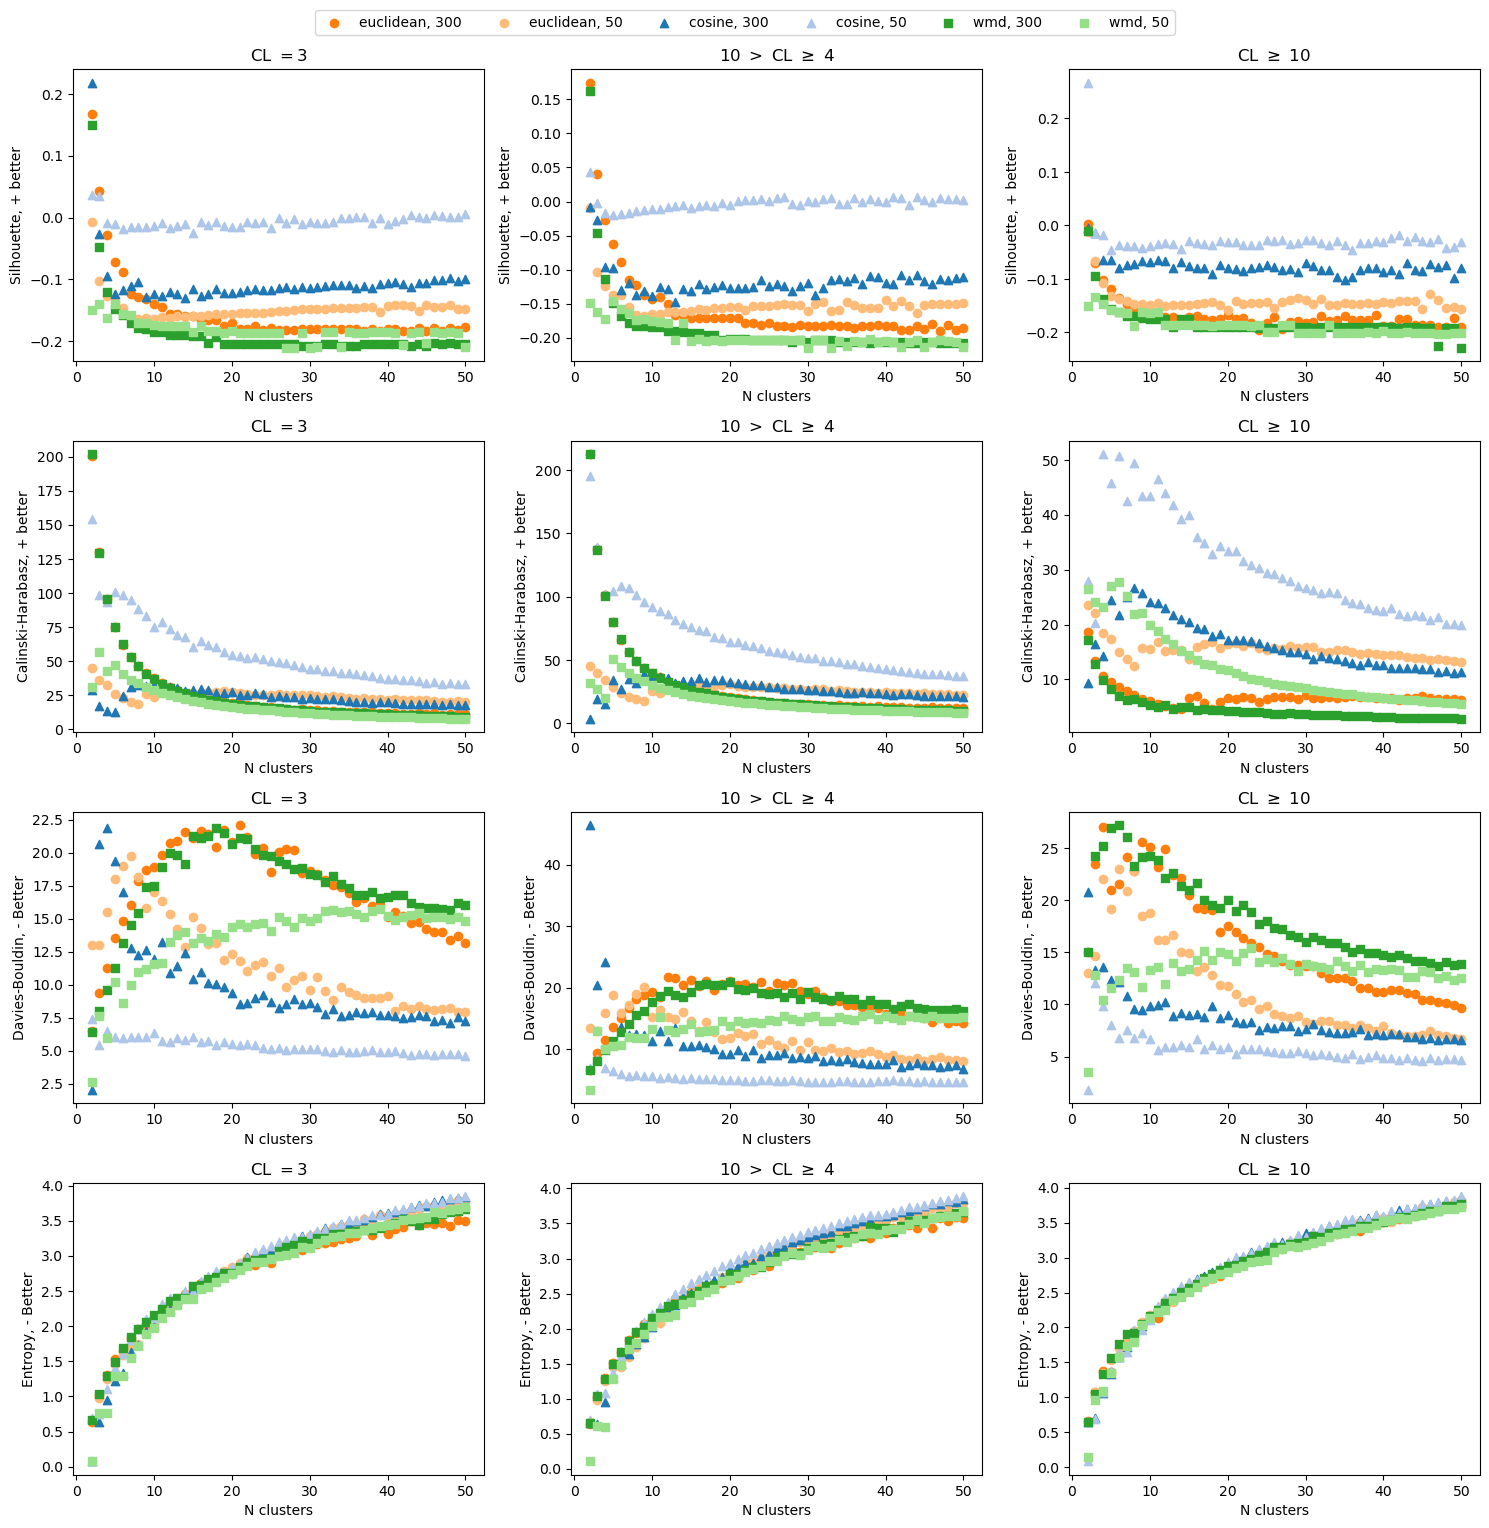

In [8]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_kmeans.loc[df_kmeans['dataset']==datasets[col],:].sort_values('n_clusters')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2])
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^')
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s')
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s')
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[row])
        handles, labels = axes[row][col].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=6)
fig.savefig(Path('../img/scores_km.png'), bbox_inches='tight')
plt.show()

In [9]:
# df_dbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_dbscan*.csv')], ignore_index=True)
# df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
# df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']
# df_dbscan['dimensions'] = df_dbscan['dataset'].apply(lambda s: s.split('_')[-1])
# df_dbscan['dataset'] = df_dbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
# df_dbscan['order'] = df_dbscan['dataset'].map(datasets_order)

In [10]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
# ncols = len(scores)
# nrows = len(datasets)
ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

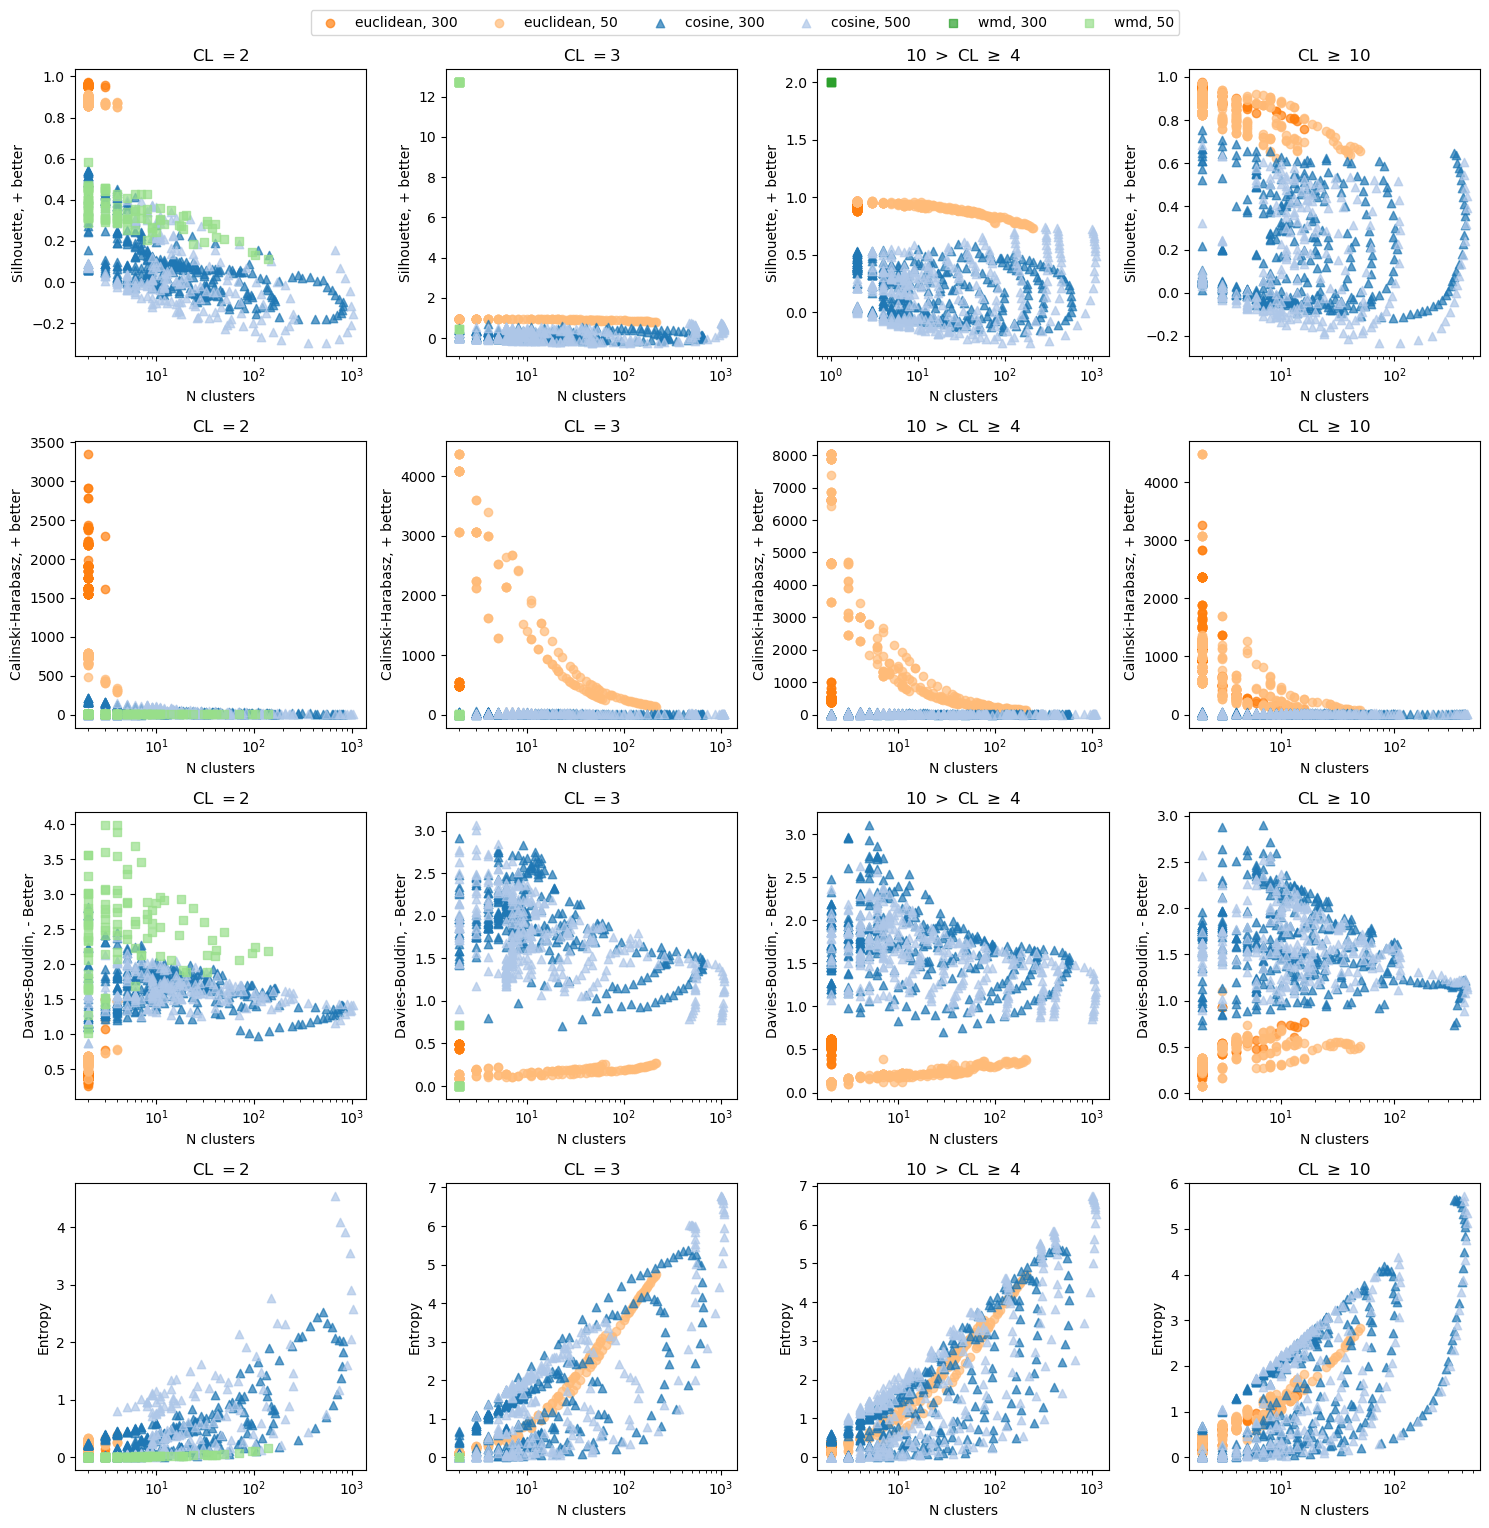

In [11]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.loc[df_dbscan['dataset']==datasets[col],:].sort_values('n_clusters')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 500', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[row])
        axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=6)
fig.savefig(Path('../img/scores_dbscan.png'), bbox_inches='tight')
plt.show()

In [12]:
# hdbscan_list = [pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')]
# df_hdbscan = pd.concat(hdbscan_list, ignore_index=True)
# df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
# df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']
# df_hdbscan['dimensions'] = df_hdbscan['dataset'].apply(lambda s: s.split('_')[-1])
# df_hdbscan['dataset'] = df_hdbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
# df_hdbscan['order'] = df_hdbscan['dataset'].map(datasets_order)

In [13]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_hdbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
# ncols = len(scores)
# nrows = len(datasets)
ncols = len(datasets)
nrows = len(scores)

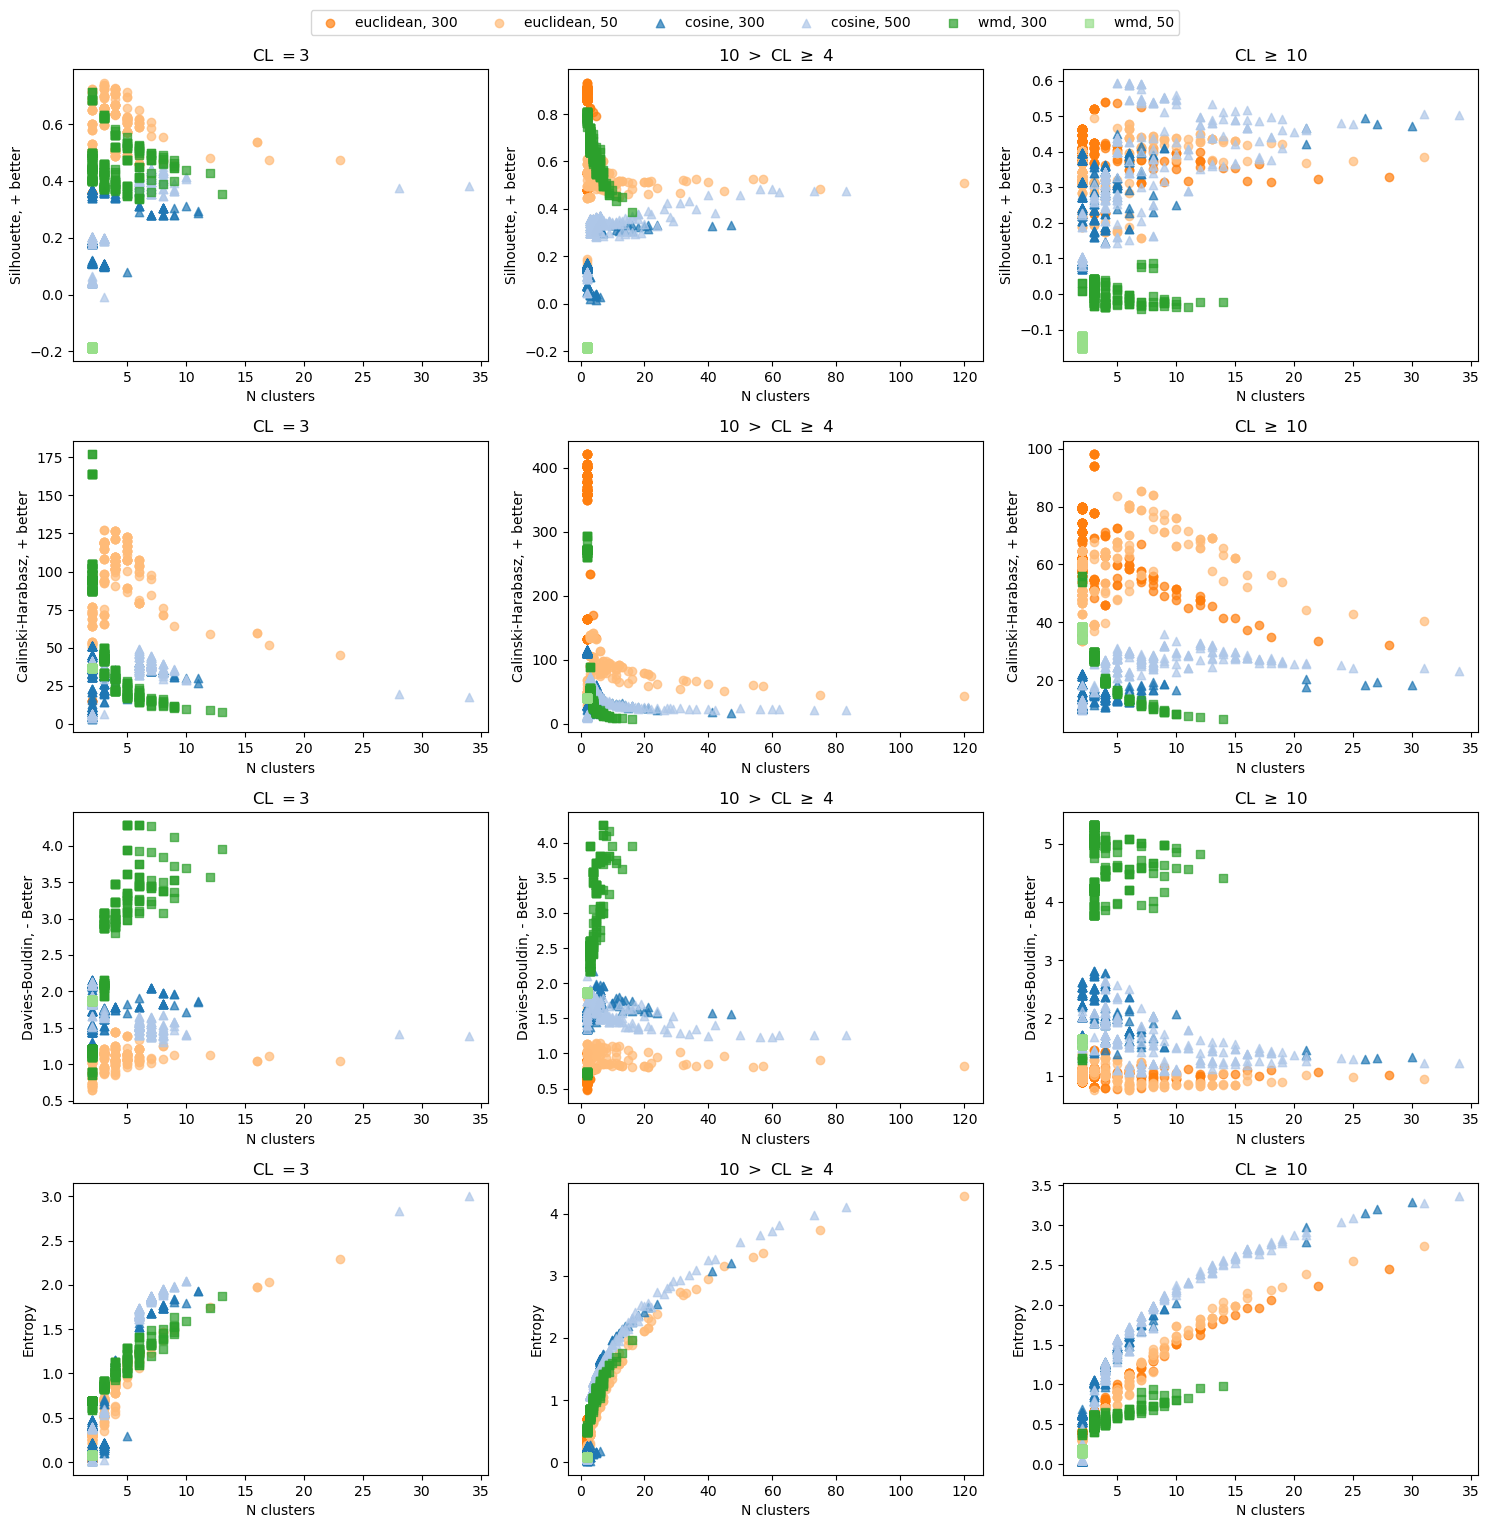

In [14]:
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_hdbscan.loc[df_hdbscan['dataset']==datasets[col],:].sort_values('n_clusters')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'cosine, 500', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='n_clusters', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[row])
        # axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=6)
fig.savefig(Path('../img/scores_hdbscan.png'), bbox_inches='tight')
plt.show()

In [15]:
# df_kmeans = df_kmeans.sort_values('order')
# df_kmeans['k_noise'] = df_kmeans['n_clusters'].astype(int)
# df_kmeans['method'] = 'KMeans'
# df_dbscan = df_dbscan.sort_values('order')
# df_dbscan['k_noise'] = df_dbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
# df_dbscan['method'] = 'DBSCAN'
# df_hdbscan = df_hdbscan.sort_values('order')
# df_hdbscan['k_noise'] = df_hdbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
# df_hdbscan['method'] = 'HDBSCAN'
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()

In [16]:
columns = ['order', 'dataset', 'name', 'dimensions', 'method', 'k_noise', 'sl_score']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_sl = pd.concat(scores)
df_sl.pivot(index=columns[:4], columns=columns[4]).droplevel([0,1])

k_noise                     sl_score  \
method                            DBSCAN    HDBSCAN KMeans     DBSCAN   
name               dimensions                                           
CL $= 2$           300         2 (0.987)        NaN    NaN   0.971257   
                   50          2 (0.987)        NaN    NaN   0.916350   
CL $= 3$           300         2 (0.986)  2 (0.980)      2   0.946196   
                   50          2 (0.000)  3 (0.982)      2  12.712286   
10 $>$ CL $\geq$ 4 300           1 (nan)  2 (0.985)      2   2.000000   
                   50          2 (0.985)  4 (0.977)      2   0.971391   
CL $\geq$ 10       300         2 (0.982)  4 (0.964)      2   0.974457   
                   50          2 (0.982)  5 (0.984)      2   0.971363   

                                                   
method                          HDBSCAN    KMeans  
name               dimensions                      
CL $= 2$           300              NaN       NaN  
                   50               NaN       NaN  
CL $= 3$           300         0.712393  0.218541  
                   50          0.746125  0.036532  
10 $>$ CL $\geq$ 4 300         0.932989  0.174593  
                   50          0.632690  0.043751  
CL $\geq$ 10       300         0.541561  0.003238  
                   50          0.594792  0.267019

In [17]:
columns = ['order', 'dataset', 'name', 'dimensions', 'method', 'k_noise', 'ch_score'] # n_clusters
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_ch = pd.concat(scores)
df_ch.pivot(index=columns[:4], columns=columns[4]).droplevel([0,1])

k_noise                       ch_score  \
method                            DBSCAN    HDBSCAN KMeans       DBSCAN   
name               dimensions                                             
CL $= 2$           300         2 (0.987)        NaN    NaN  3354.887297   
                   50          2 (0.986)        NaN    NaN   794.803398   
CL $= 3$           300         2 (0.986)  2 (0.980)      2   538.948159   
                   50          2 (0.985)  3 (0.979)      2  4375.641036   
10 $>$ CL $\geq$ 4 300         2 (0.985)  2 (0.984)      2  1015.532150   
                   50          2 (0.985)  4 (0.977)      2  8049.609924   
CL $\geq$ 10       300         2 (0.982)  3 (0.957)      8  3260.838531   
                   50          2 (0.982)  7 (0.951)      4  4488.032424   

                                                       
method                            HDBSCAN      KMeans  
name               dimensions                          
CL $= 2$           300                NaN         NaN  
                   50                 NaN         NaN  
CL $= 3$           300         177.225357  202.134048  
                   50          127.244265  154.210065  
10 $>$ CL $\geq$ 4 300         421.713111  212.991721  
                   50          141.183855  195.654306  
CL $\geq$ 10       300          98.262374   26.631553  
                   50           85.513587   51.139350

In [18]:
columns = ['order', 'dataset',  'name', 'dimensions', 'method', 'k_noise', 'db_score'] # n_clusters
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_db = pd.concat(scores)
df_db.pivot(index=columns[:4], columns=columns[4]).droplevel([0,1])

k_noise                    db_score  \
method                            DBSCAN    HDBSCAN KMeans    DBSCAN   
name               dimensions                                          
CL $= 2$           300         2 (0.987)        NaN    NaN  0.261363   
                   50          2 (0.987)        NaN    NaN  0.352527   
CL $= 3$           300         2 (0.986)  2 (0.980)      2  0.436283   
                   50          2 (0.000)  2 (0.982)      2  0.003072   
10 $>$ CL $\geq$ 4 300         2 (0.985)  2 (0.985)      2  0.326818   
                   50          2 (0.985)  3 (0.978)      2  0.077740   
CL $\geq$ 10       300         2 (0.982)  5 (0.963)     50  0.149425   
                   50          2 (0.982)  3 (0.965)      2  0.080403   

                                                   
method                          HDBSCAN    KMeans  
name               dimensions                      
CL $= 2$           300              NaN       NaN  
                   50               NaN       NaN  
CL $= 3$           300         0.854893  1.992837  
                   50          0.642137  2.631302  
10 $>$ CL $\geq$ 4 300         0.475811  6.566408  
                   50          0.737177  3.356306  
CL $\geq$ 10       300         0.784689  6.572528  
                   50          0.759537  1.764784

In [19]:
columns = ['order', 'dataset',  'name', 'dimensions', 'method', 'k_noise', 'entropy']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_en = pd.concat(scores)
df_en.pivot(index=columns[:4], columns=columns[4]).droplevel([0,1])

k_noise                     entropy  \
method                            DBSCAN    HDBSCAN KMeans    DBSCAN   
name               dimensions                                          
CL $= 2$           300         2 (0.003)        NaN    NaN  0.000874   
                   50          2 (0.000)        NaN    NaN  0.000871   
CL $= 3$           300         2 (0.007)  2 (0.032)      2  0.002153   
                   50          2 (0.098)  2 (0.578)      2  0.001262   
10 $>$ CL $\geq$ 4 300         2 (0.001)  2 (0.601)      2  0.001961   
                   50          2 (0.029)  2 (0.793)      2  0.001080   
CL $\geq$ 10       300         2 (0.017)  2 (0.544)      2  0.003389   
                   50          2 (0.006)  2 (0.710)      2  0.004805   

                                                   
method                          HDBSCAN    KMeans  
name               dimensions                      
CL $= 2$           300              NaN       NaN  
                   50               NaN       NaN  
CL $= 3$           300         0.005836  0.075709  
                   50          0.010286  0.084231  
10 $>$ CL $\geq$ 4 300         0.011600  0.634100  
                   50          0.044040  0.103807  
CL $\geq$ 10       300         0.031174  0.650821  
                   50          0.048659  0.084204

In [20]:
tmp_1 = df_sl.pivot(index=columns[:4], columns=columns[4]).droplevel([0,1])
tmp_1.columns = tmp_1.columns.droplevel(0)
tmp_2 = df_ch.pivot(index=columns[:4], columns=columns[4]).droplevel([0,1])
tmp_2.columns = tmp_2.columns.droplevel(0)
tmp_3 = df_db.pivot(index=columns[:4], columns=columns[4]).droplevel([0,1])
tmp_3.columns = tmp_3.columns.droplevel(0)
tmp_4 = df_en.pivot(index=columns[:4], columns=columns[4]).droplevel([0,1])
tmp_4.columns = tmp_4.columns.droplevel(0)

In [21]:
pd.concat([tmp_1, tmp_2, tmp_3, tmp_4])

method                            DBSCAN    HDBSCAN  KMeans       DBSCAN  \
name               dimensions                                              
CL $= 2$           300         2 (0.987)        NaN     NaN     0.971257   
                   50          2 (0.987)        NaN     NaN     0.916350   
CL $= 3$           300         2 (0.986)  2 (0.980)       2     0.946196   
                   50          2 (0.000)  3 (0.982)       2    12.712286   
10 $>$ CL $\geq$ 4 300           1 (nan)  2 (0.985)       2     2.000000   
                   50          2 (0.985)  4 (0.977)       2     0.971391   
CL $\geq$ 10       300         2 (0.982)  4 (0.964)       2     0.974457   
                   50          2 (0.982)  5 (0.984)       2     0.971363   
CL $= 2$           300         2 (0.987)        NaN     NaN  3354.887297   
                   50          2 (0.986)        NaN     NaN   794.803398   
CL $= 3$           300         2 (0.986)  2 (0.980)       2   538.948159   
                   50          2 (0.985)  3 (0.979)       2  4375.641036   
10 $>$ CL $\geq$ 4 300         2 (0.985)  2 (0.984)       2  1015.532150   
                   50          2 (0.985)  4 (0.977)       2  8049.609924   
CL $\geq$ 10       300         2 (0.982)  3 (0.957)       8  3260.838531   
                   50          2 (0.982)  7 (0.951)       4  4488.032424   
CL $= 2$           300         2 (0.987)        NaN     NaN     0.261363   
                   50          2 (0.987)        NaN     NaN     0.352527   
CL $= 3$           300         2 (0.986)  2 (0.980)       2     0.436283   
                   50          2 (0.000)  2 (0.982)       2     0.003072   
10 $>$ CL $\geq$ 4 300         2 (0.985)  2 (0.985)       2     0.326818   
                   50          2 (0.985)  3 (0.978)       2     0.077740   
CL $\geq$ 10       300         2 (0.982)  5 (0.963)      50     0.149425   
                   50          2 (0.982)  3 (0.965)       2     0.080403   
CL $= 2$           300         2 (0.003)        NaN     NaN     0.000874   
                   50          2 (0.000)        NaN     NaN     0.000871   
CL $= 3$           300         2 (0.007)  2 (0.032)       2     0.002153   
                   50          2 (0.098)  2 (0.578)       2     0.001262   
10 $>$ CL $\geq$ 4 300         2 (0.001)  2 (0.601)       2     0.001961   
                   50          2 (0.029)  2 (0.793)       2     0.001080   
CL $\geq$ 10       300         2 (0.017)  2 (0.544)       2     0.003389   
                   50          2 (0.006)  2 (0.710)       2     0.004805   

method                            HDBSCAN      KMeans  
name               dimensions                          
CL $= 2$           300                NaN         NaN  
                   50                 NaN         NaN  
CL $= 3$           300           0.712393    0.218541  
                   50            0.746125    0.036532  
10 $>$ CL $\geq$ 4 300           0.932989    0.174593  
                   50            0.632690    0.043751  
CL $\geq$ 10       300           0.541561    0.003238  
                   50            0.594792    0.267019  
CL $= 2$           300                NaN         NaN  
                   50                 NaN         NaN  
CL $= 3$           300         177.225357  202.134048  
                   50          127.244265  154.210065  
10 $>$ CL $\geq$ 4 300         421.713111  212.991721  
                   50          141.183855  195.654306  
CL $\geq$ 10       300          98.262374   26.631553  
                   50           85.513587   51.139350  
CL $= 2$           300                NaN         NaN  
                   50                 NaN         NaN  
CL $= 3$           300           0.854893    1.992837  
                   50            0.642137    2.631302  
10 $>$ CL $\geq$ 4 300           0.475811    6.566408  
                   50            0.737177    3.356306  
CL $\geq$ 10       300           0.784689    6.572528  
               

In [22]:
print(
    pd.concat([tmp_1, tmp_2, tmp_3, tmp_4]).\
    to_html(na_rep='-', float_format="%.3f")
)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>method</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
      <th>DBSCAN</th>
      <th>HDBSCAN</th>
      <th>KMeans</th>
    </tr>
    <tr>
      <th>name</th>
      <th>dimensions</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="2" valign="top">CL $= 2$</th>
      <th>300</th>
      <td>2 (0.987)</td>
      <td>-</td>
      <td>-</td>
      <td>0.971</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th>50</th>
      <td>2 (0.987)</td>
      <td>-</td>
      <td>-</td>
      <td>0.916</td>
      <td>-</td>
      <td>-</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">CL $= 3$</th>
      <th>300</th>
      <td>2 (0.986)</td>
      <td>2 (0.980)</td>
      <td>2</td>
      <td>0.946</td>
      <td>0.712</td>
      <td>0.219

In [23]:
print(
    df_sl.pivot(index=columns[:3], columns=columns[3]).droplevel(0).\
    to_html(na_rep='-', float_format="%.3f")
)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
print(
    df_ch.pivot(index=columns[:3], columns=columns[3]).droplevel(0).\
    to_html(na_rep='-', float_format="%.3f")
)
# print(
#     df_ch.pivot_table(
#         index=['dataset', 'dimensions'], columns=['method'], values=['n_clusters','ch_score'],fill_value=0
#     ).to_html(na_rep='-', float_format="%.3f")
# )

In [ ]:
print(
    df_db.pivot(index=columns[:3], columns=columns[3]).droplevel(0).\
    to_html(na_rep='-', float_format="%.3f")
)
# print(
#     df_db.pivot_table(
#         index=['dataset', 'dimensions'], columns=['method'], values=['n_clusters','db_score'],fill_value=0
#     ).to_html(na_rep='-', float_format="%.3f")
# )

In [ ]:
print(
    df_en.pivot(index=columns[:3], columns=columns[3]).droplevel(0).\
    to_html(na_rep='-', float_format="%.3f")
)
# print(
#     df_en.pivot_table(
#         index=['dataset', 'dimensions'], columns=['method'], values=['n_clusters','entropy'],fill_value=0
#     ).to_html(na_rep='-', float_format="%.3f")
# )

In [ ]:
methods = ['kmeans', 'dbscan', 'hdbscan']
datasets = np.sort(df_dbscan['dataset'].unique())

In [ ]:
# X = df_hdbscan.sort_values('n_clusters')
# fig, axes = plt.subplots(nrows, ncols, figsize=(16,20))
# for row in range(nrows):
#     for col in range(ncols):
#         x = X[(X['dataset'] == datasets[row]) & (X['distance']=='cosine')]
#         axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='cosine', alpha=0.3)
#         x = X[(X['dataset'] == datasets[row]) & (X['distance']=='euclidean')]
#         axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='euclidean', alpha=0.3, marker='^')
#         x = X[(X['dataset'] == datasets[row]) & (X['distance']=='wmd')]
#         axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='wmd', alpha=0.3, marker='s')
#         # axes[row][col].legend(title='Distance')
#         axes[row][col].set_title(f'{datasets_dict[datasets[row]]}')
#         axes[row][col].set_xlabel('N clusters')
#         axes[row][col].set_ylabel(score_names[col])
#         handles, labels = axes[row][col].get_legend_handles_labels()

# # fig.tight_layout()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=3) 
# fig.savefig(Path('../img/scores_hdbscan.png'), bbox_inches='tight')
# plt.show()
# print(tab_hdbscan.to_latex(float_format="%.3f", longtable=True, decimal=',', label='tab:hdbscanscores', caption='HDBSCAN Best Scores'))

In [ ]:
datasets

In [ ]:
df_kmeans

In [ ]:
df_kmeans['dataset'].unique()

In [ ]:
df_kmeans = df_kmeans.sort_values('order')
df_dbscan = df_dbscan.sort_values('order')
df_hdbscan = df_hdbscan.sort_values('order')
columns1 = ['order', 'dataset', 'dimensions', 'n_clusters', 'sl_score']
columns2 = ['order', 'dataset', 'dimensions', 'n_clusters', 'prop_noise', 'sl_score']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns1].sort_values(columns1[-1],ascending=False).head(1)
        tmp1['method'] = 'KMeans'
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns2].sort_values(columns2[-1],ascending=False).head(1)
        tmp2['method'] = 'DBSCAN'
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns2].sort_values(columns2[-1],ascending=False).head(1)
        tmp3['method'] = 'HDBSCAN'
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_sl = pd.concat(scores)
df_sl.pivot(index=['dataset', 'dimensions'], columns=['method'])

In [ ]:
df_kmeans = df_kmeans.sort_values('order')
df_dbscan = df_dbscan.sort_values('order')
df_hdbscan = df_hdbscan.sort_values('order')
columns1 = ['dataset','dimensions', 'n_clusters', 'ch_score']
columns2 = ['dataset','dimensions', 'n_clusters', 'prop_noise', 'ch_score']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns1].sort_values(columns1[-1],ascending=False).head(1)
        tmp1['method'] = 'KMeans'
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns2].sort_values(columns2[-1],ascending=False).head(1)
        tmp2['method'] = 'DBSCAN'
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns2].sort_values(columns2[-1],ascending=False).head(1)
        tmp3['method'] = 'HDBSCAN'
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_ch = pd.concat(scores)
df_ch.pivot(index=['dataset', 'dimensions'], columns=['method'])

In [ ]:
df_sl.pivot(index=['dataset', 'dimensions'], columns=['method'])

In [ ]:
df_kmeans = df_kmeans.sort_values('order')
df_dbscan = df_dbscan.sort_values('order')
df_hdbscan = df_hdbscan.sort_values('order')
columns = ['dataset','dimensions', 'n_clusters', 'ch_score']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp1['method'] = 'KMeans'
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp2['method'] = 'DBSCAN'
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1)
        tmp3['method'] = 'HDBSCAN'
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_ch = pd.concat(scores)
df_ch.pivot(index=['dataset','dimensions'],columns=['method'])

In [ ]:
df_dbscan

In [ ]:
df_kmeans = df_kmeans.sort_values('order')
df_dbscan = df_dbscan.sort_values('order')
df_hdbscan = df_hdbscan.sort_values('order')
columns = ['dataset','dimensions', 'n_clusters', 'entropy']
scores = []
for dat in datasets:
    for dim in ['300', '50']:
        tmp1 = df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp1['method'] = 'KMeans'
        tmp2 = df_dbscan.loc[(df_dbscan['dataset']==dat) &(df_dbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp2['method'] = 'DBSCAN'
        tmp3 = df_hdbscan.loc[(df_hdbscan['dataset']==dat) &(df_hdbscan['dimensions']==dim),columns].sort_values(columns[-1],ascending=True).head(1)
        tmp3['method'] = 'HDBSCAN'
        scores.append(pd.concat([tmp1, tmp2, tmp3]))
df_en = pd.concat(scores)
df_en.pivot(index=['dataset','dimensions'], columns=['method'])

In [ ]:
df_kmeans = df_kmeans.sort_values('order')
columns = ['dataset','dimensions', 'n_clusters', 'sl_score']
km_sl = []
for dat in datasets:
    for dim in ['300', '50']:
        km_sl.append(df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values('sl_score',ascending=False).head(1))
df_km_sc = pd.concat(km_sl)

In [ ]:
df_km_sc

In [ ]:
df_kmeans = df_kmeans.sort_values('order')
columns = ['dataset','dimensions', 'n_clusters', 'ch_score']
km_ls = []
for dat in datasets:
    for dim in ['300', '50']:
        km_ls.append(df_kmeans.loc[(df_kmeans['dataset']==dat) &(df_kmeans['dimensions']==dim),columns].sort_values(columns[-1],ascending=False).head(1))
# df_km_sc = pd.concat(km_ls)

In [ ]:
df = df_kmeans.loc[df_kmeans['dataset']==datasets[0],['dataset','n_clusters', 'sl_score',]].sort_values('sl_score',ascending=False).head(1)

In [ ]:
for score in scores:
    for i, row in df.iterrows():
        pd.DataFrame({'dataset': row['dataset'], 'n_clusters': row['n_clusters'],'metric': score, 'score': row[score]}

In [ ]:
km_sl = []
for d in datasets:
    km_sl.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'sl_score',]].sort_values('sl_score',ascending=False).head(1))
df_km_sl = pd.concat(km_sl)
df_km_sl

In [ ]:
[f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean' for i, r in df_km_sl.iterrows()]

In [ ]:
[r["dataset"] for i, r in df_km_sl.iterrows()]

In [ ]:
km_ch = []
for d in datasets:
    km_ch.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'ch_score']].sort_values('ch_score',ascending=False).head(1))
df_km_ch = pd.concat(km_ch)
df_km_ch

In [ ]:
for i, r in df_km_ch.iterrows():
    print(f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean')

In [ ]:
km_db = []
for d in datasets:
    # km_db.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'db_score']].sort_values('db_score',ascending=True).head(1))
    # (df_kmeans['dataset']==datasets[row]) & (df_kmeans['n_clusters']<=30)
    km_db.append(df_kmeans.loc[(df_kmeans['dataset']==d) & (df_kmeans['n_clusters']<=50),['dataset','n_clusters', 'db_score']].sort_values('db_score',ascending=True).head(1))
df_km_db = pd.concat(km_db)
df_km_db

In [ ]:
km_en = []
for d in datasets:
    # km_en.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'db_score']].sort_values('db_score',ascending=True).head(1))
    # (df_kmeans['dataset']==datasets[row]) & (df_kmeans['n_clusters']<=30)
    km_en.append(df_kmeans.loc[(df_kmeans['dataset']==d) & (df_kmeans['entropy']<=50),['dataset','n_clusters', 'entropy']].sort_values('entropy',ascending=True).head(1))
df_km_en = pd.concat(km_en)
df_km_en

In [ ]:
for i, r in df_km_db.iterrows():
    print(f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean')

In [ ]:
l_sl = []
for d in datasets:
    l_sl.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'sl_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('sl_score',ascending=False).head(1))
df_dbs_sl = pd.concat(l_sl)
df_dbs_sl

In [ ]:
l_ch = []
for d in datasets:
    l_ch.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'ch_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('ch_score',ascending=False).head(1))
df_dbs_ch = pd.concat(l_ch)
df_dbs_ch

In [ ]:
l_db = []
for d in datasets:
    l_db.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'db_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('db_score',ascending=True).head(1))
df_dbs_db = pd.concat(l_db)
df_dbs_db

In [ ]:
l_en = []
for d in datasets:
    l_en.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'entropy', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('entropy',ascending=True).head(1))
df_dbs_en = pd.concat(l_en)
df_dbs_en

In [ ]:
l_sl = []
for d in datasets:
    l_sl.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'sl_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('sl_score',ascending=False).head(1))
df_hdb_sl = pd.concat(l_sl)
df_hdb_sl

In [ ]:
l_ch = []
for d in datasets:
    l_ch.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'ch_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('ch_score',ascending=False).head(1))
df_hdb_ch = pd.concat(l_ch)
df_hdb_ch

In [ ]:
l_db = []
for d in datasets:
    l_db.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'db_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('db_score',ascending=True).head(1))
df_hdb_db = pd.concat(l_db)
df_hdb_db

In [ ]:
l_en = []
for d in datasets:
    l_en.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'entropy', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('entropy',ascending=True).head(1))
df_hdb_en = pd.concat(l_en)
df_hdb_en

In [5]:
df_dbscan

,distance,dataset,epsilon,min_pts,n_clusters,sl_score,ch_score,db_score,entropy,n_noise,Unnamed: 9,size,prop_noise,dimensions,order,name,k_noise,method
22677,euclidean,chains_eq_2,1.00,13,2,0.863051,747.924487,0.670437,0.296033,23497.0,NaN,23841,0.985571,50,0,CL $= 2$,2 (0.986),DBSCAN
7556,wmd,chains_eq_2,0.73,12,1,NaN,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
7557,wmd,chains_eq_2,0.73,13,1,NaN,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
7558,wmd,chains_eq_2,0.73,14,1,NaN,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
7559,wmd,chains_eq_2,0.73,15,1,NaN,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15498,euclidean,chains_ge_10,0.74,2,2,0.945102,1490.137353,0.256137,0.337577,5220.0,NaN,5324,0.980466,300,3,CL $\geq$ 10,2 (0.980),DBSCAN
15499,euclidean,chains_ge_10,0.74,3,2,0.945102,1490.137353,0.256137,0.337577,5220.0,NaN,5324,0.980466,300,3,CL $\geq$ 10,2 (0.980),DBSCAN
15500,euclidean,chains_ge_10,0.74,4,2,0.945102,1490.137353,0.256137,0.337577,5220.0,NaN,5324,0.980466,300,3,CL $\geq$ 10,2 (0.980),DBSCAN
15494,euclidean,chains_ge_10,0.73,12,1,NaN,NaN,NaN,NaN,5231.0,NaN,5324,0.982532,300,3,CL $\geq$ 10,1 (0.983),DBSCAN


In [8]:
distances = df_dbscan['distance'].unique()

In [9]:
distances

array(['euclidean', 'wmd', 'cosine'], dtype=object)

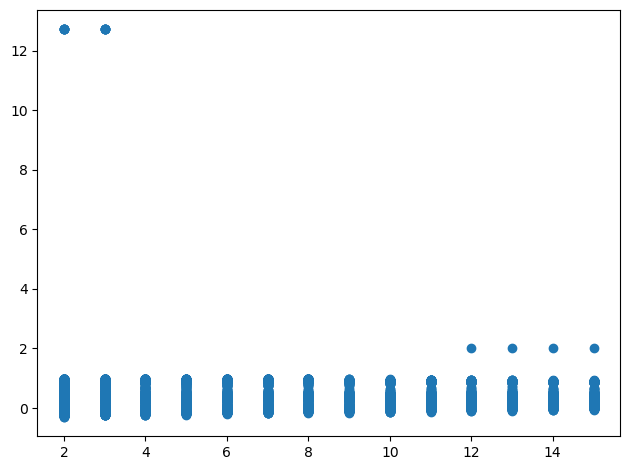

In [11]:
fig, ax = plt.subplots(1,1)
ax.scatter(x='min_pts',y='sl_score', data=df_dbscan)
plt.show()

In [12]:
df_hdbscan

,distance,dataset,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,entropy,size,prop_noise,dimensions,order,name,k_noise,method
0,cosine,chains_eq_3,5,5,34,8243,0.381033,17.552875,1.388532,2.999412,8769,0.940016,50,1,CL $= 3$,34 (0.940),HDBSCAN
1869,wmd,chains_eq_3,9,18,3,8486,0.382028,43.163738,2.922272,0.819609,8769,0.967727,300,1,CL $= 3$,3 (0.968),HDBSCAN
1870,wmd,chains_eq_3,9,19,3,8480,0.371560,43.447553,2.871585,0.842926,8769,0.967043,300,1,CL $= 3$,3 (0.967),HDBSCAN
1871,wmd,chains_eq_3,9,20,3,8484,0.378164,42.652808,3.071641,0.853565,8769,0.967499,300,1,CL $= 3$,3 (0.967),HDBSCAN
1872,wmd,chains_eq_3,10,5,6,8521,0.447462,14.320614,4.280473,1.406183,8769,0.971719,300,1,CL $= 3$,6 (0.972),HDBSCAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979,cosine,chains_ge_10,15,8,8,5108,0.339879,24.955287,1.679751,1.981561,5324,0.959429,50,3,CL $\geq$ 10,8 (0.959),HDBSCAN
2978,cosine,chains_ge_10,15,7,8,5093,0.306965,24.402091,1.821168,1.972585,5324,0.956612,50,3,CL $\geq$ 10,8 (0.957),HDBSCAN
2977,cosine,chains_ge_10,15,6,11,5038,0.290199,24.141317,1.788552,2.284764,5324,0.946281,50,3,CL $\geq$ 10,11 (0.946),HDBSCAN
4606,wmd,chains_ge_10,20,19,2,2600,-0.145960,34.674008,1.633185,0.148854,5324,0.488355,50,3,CL $\geq$ 10,2 (0.488),HDBSCAN


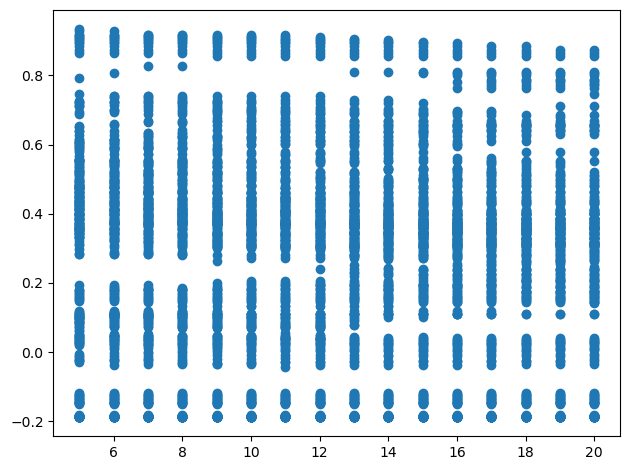

In [13]:
fig, ax = plt.subplots(1,1)
ax.scatter(x='min_clt_size',y='sl_score', data=df_hdbscan)
plt.show()

In [31]:
df_dbscan

,distance,dataset,epsilon,min_pts,n_clusters,sl_score,ch_score,db_score,entropy,n_noise,Unnamed: 9,size,prop_noise,dimensions,order,name,k_noise,method
22677,euclidean,chains_eq_2,1.00,13,2,0.863051,747.924487,0.670437,0.296033,23497.0,NaN,23841,0.985571,50,0,CL $= 2$,2 (0.986),DBSCAN
7556,wmd,chains_eq_2,0.73,12,1,NaN,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
7557,wmd,chains_eq_2,0.73,13,1,NaN,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
7558,wmd,chains_eq_2,0.73,14,1,NaN,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
7559,wmd,chains_eq_2,0.73,15,1,NaN,NaN,NaN,NaN,NaN,NaN,23841,NaN,300,0,CL $= 2$,1 (nan),DBSCAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15498,euclidean,chains_ge_10,0.74,2,2,0.945102,1490.137353,0.256137,0.337577,5220.0,NaN,5324,0.980466,300,3,CL $\geq$ 10,2 (0.980),DBSCAN
15499,euclidean,chains_ge_10,0.74,3,2,0.945102,1490.137353,0.256137,0.337577,5220.0,NaN,5324,0.980466,300,3,CL $\geq$ 10,2 (0.980),DBSCAN
15500,euclidean,chains_ge_10,0.74,4,2,0.945102,1490.137353,0.256137,0.337577,5220.0,NaN,5324,0.980466,300,3,CL $\geq$ 10,2 (0.980),DBSCAN
15494,euclidean,chains_ge_10,0.73,12,1,NaN,NaN,NaN,NaN,5231.0,NaN,5324,0.982532,300,3,CL $\geq$ 10,1 (0.983),DBSCAN


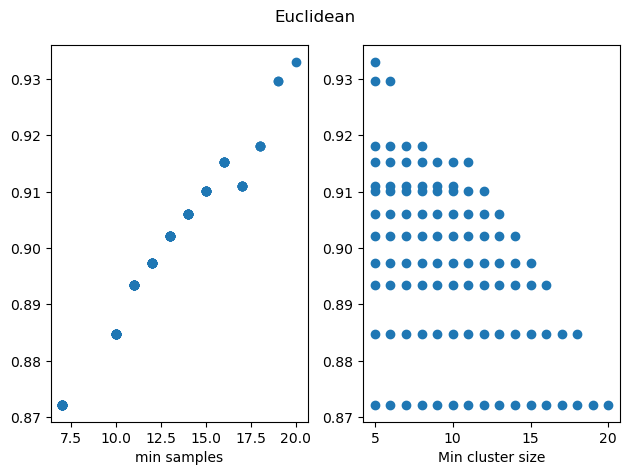

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2)
df_subset = df_hdbscan[df_hdbscan['distance']=='euclidean'].sort_values(['sl_score','min_samples', 'min_clt_size'], ascending=False)
ax1.scatter(x='min_samples',y='sl_score', data=df_subset.head(100))
ax1.set_xlabel('min samples')
ax2.scatter(x='min_clt_size',y='sl_score', data=df_subset.head(100))
ax2.set_xlabel('Min cluster size')
fig.suptitle('Euclidean')
plt.show()

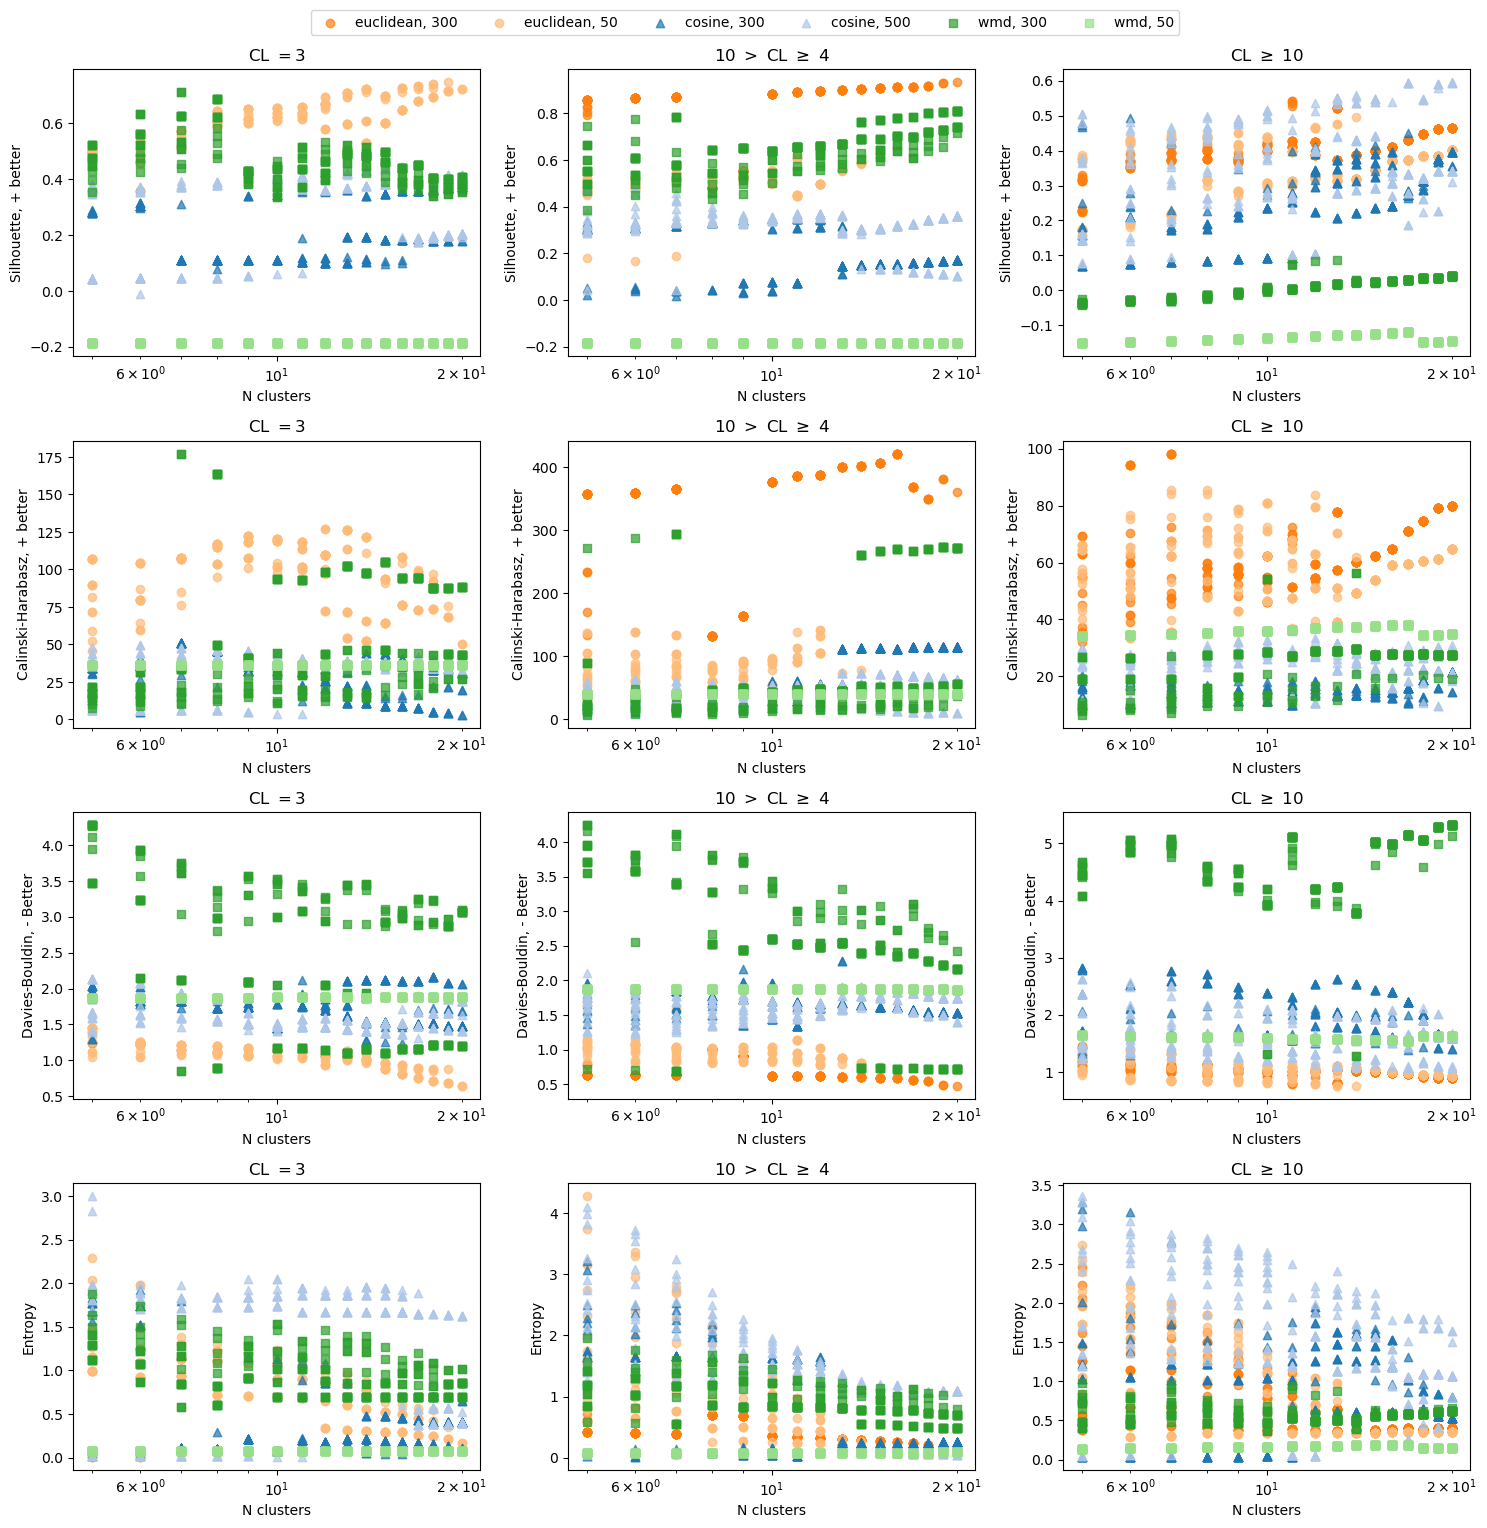

In [32]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_hdbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']

ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_hdbscan.loc[df_hdbscan['dataset']==datasets[col],:].sort_values('min_samples')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='min_samples', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='min_samples', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='min_samples', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='min_samples', y=scores[row], label=f'cosine, 500', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='min_samples', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='min_samples', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('Min samples')
        axes[row][col].set_ylabel(score_names[row])
        axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=6)
# fig.savefig(Path('../img/scores_hdbscan.png'), bbox_inches='tight')
plt.show()

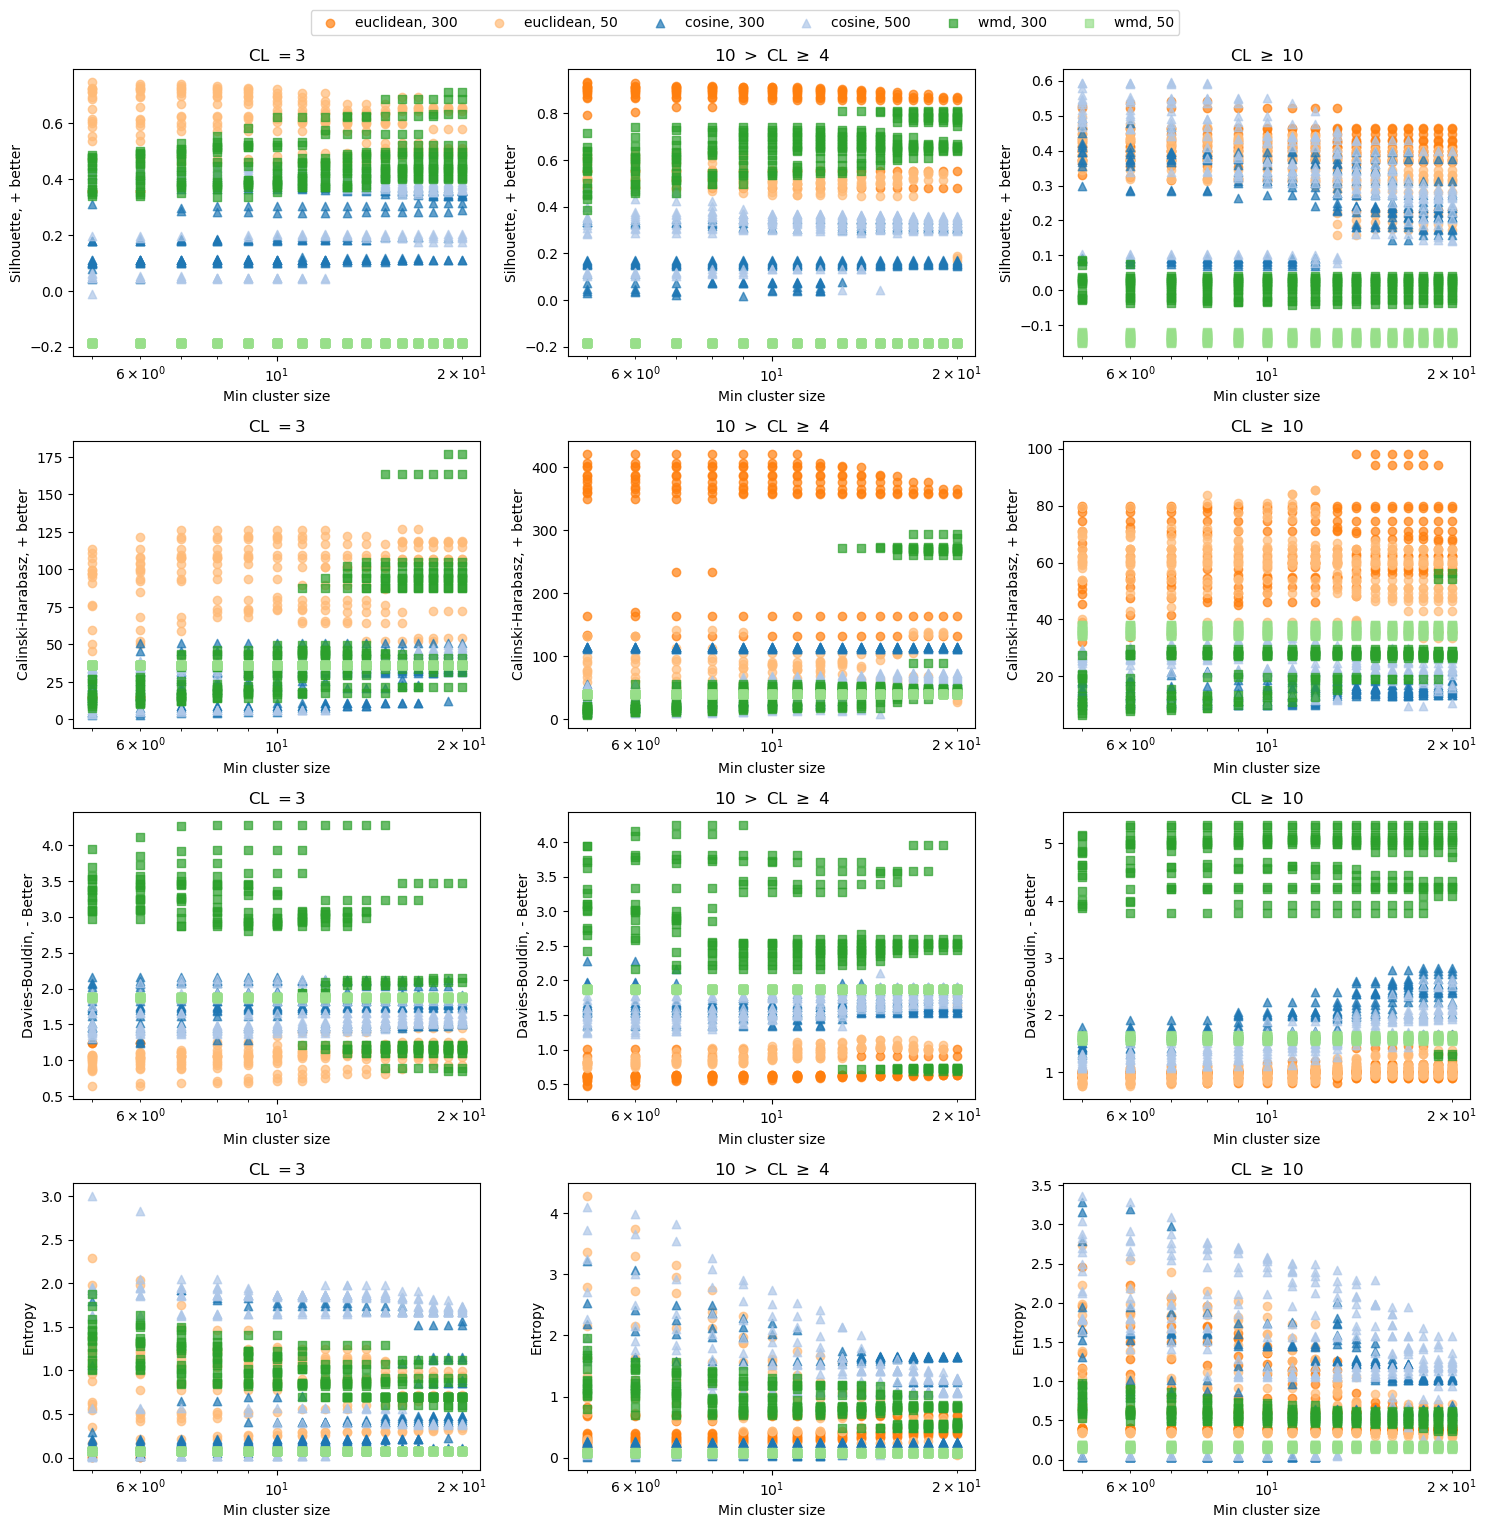

In [33]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_hdbscan.sort_values(by='order')['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']

ncols = len(datasets)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_hdbscan.loc[df_hdbscan['dataset']==datasets[col],:].sort_values('min_clt_size')
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='min_clt_size', y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x='min_clt_size', y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='min_clt_size', y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x='min_clt_size', y=scores[row], label=f'cosine, 500', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='min_clt_size', y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x='min_clt_size', y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel('Min cluster size')
        axes[row][col].set_ylabel(score_names[row])
        axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=6)
# fig.savefig(Path('../img/scores_hdbscan.png'), bbox_inches='tight')
plt.show()

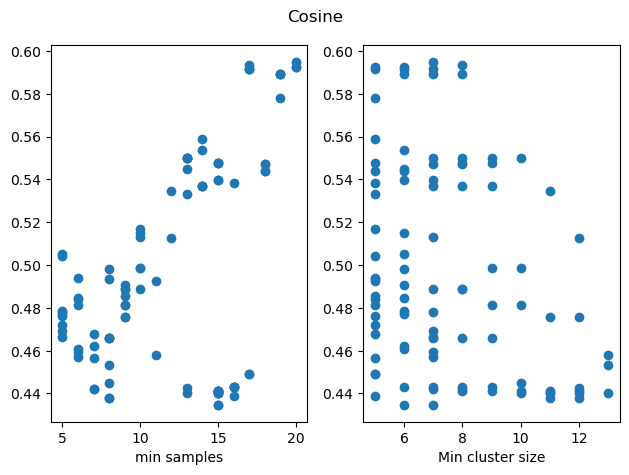

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2)
df_subset = df_hdbscan[df_hdbscan['distance']=='cosine'].sort_values(['sl_score','min_samples', 'min_clt_size'], ascending=False)
ax1.scatter(x='min_samples',y='sl_score', data=df_subset.head(100))
ax1.set_xlabel('min samples')
ax2.scatter(x='min_clt_size',y='sl_score', data=df_subset.head(100))
ax2.set_xlabel('Min cluster size')
fig.suptitle('Cosine')
plt.show()

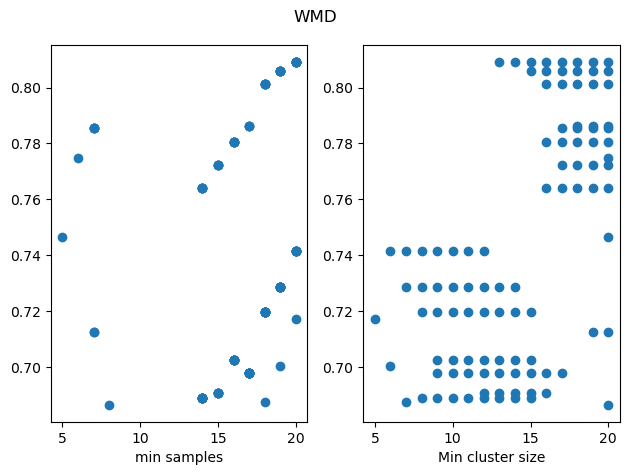

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2)
df_subset = df_hdbscan[df_hdbscan['distance']=='wmd'].sort_values(['sl_score','min_samples', 'min_clt_size'], ascending=False)
ax1.scatter(x='min_samples',y='sl_score', data=df_subset.head(100))
ax1.set_xlabel('min samples')
ax2.scatter(x='min_clt_size',y='sl_score', data=df_subset.head(100))
ax2.set_xlabel('Min cluster size')
fig.suptitle('WMD')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1)
df_subset = df_hdbscan.sort_values('sl_score', ascending=False)
ax.scatter(x='min_samples',y='sl_score', data=df_subset.head(100))
plt.show()

In [19]:
df_hdbscan[df_hdbscan['distance']=='euclidean'].sort_values('sl_score', ascending=False).head(20)

,distance,dataset,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,entropy,size,prop_noise,dimensions,order,name,k_noise,method
1551,euclidean,chains_ge_4_lt_10,5,20,2,9531,0.932989,361.380079,0.475811,0.149995,9676,0.985014,300,2,10 $>$ CL $\geq$ 4,2 (0.985),HDBSCAN
1550,euclidean,chains_ge_4_lt_10,5,19,2,9530,0.929697,381.321085,0.492342,0.171411,9676,0.984911,300,2,10 $>$ CL $\geq$ 4,2 (0.985),HDBSCAN
1566,euclidean,chains_ge_4_lt_10,6,19,2,9530,0.929697,381.321085,0.492342,0.171411,9676,0.984911,300,2,10 $>$ CL $\geq$ 4,2 (0.985),HDBSCAN
1581,euclidean,chains_ge_4_lt_10,7,18,2,9528,0.918112,348.880913,0.552355,0.210283,9676,0.984704,300,2,10 $>$ CL $\geq$ 4,2 (0.985),HDBSCAN
1597,euclidean,chains_ge_4_lt_10,8,18,2,9528,0.918112,348.880913,0.552355,0.210283,9676,0.984704,300,2,10 $>$ CL $\geq$ 4,2 (0.985),HDBSCAN
1549,euclidean,chains_ge_4_lt_10,5,18,2,9528,0.918112,348.880913,0.552355,0.210283,9676,0.984704,300,2,10 $>$ CL $\geq$ 4,2 (0.985),HDBSCAN
1565,euclidean,chains_ge_4_lt_10,6,18,2,9528,0.918112,348.880913,0.552355,0.210283,9676,0.984704,300,2,10 $>$ CL $\geq$ 4,2 (0.985),HDBSCAN
1627,euclidean,chains_ge_4_lt_10,10,16,2,9526,0.915314,421.713111,0.583917,0.262177,9676,0.984498,300,2,10 $>$ CL $\geq$ 4,2 (0.984),HDBSCAN
1563,euclidean,chains_ge_4_lt_10,6,16,2,9526,0.915314,421.713111,0.583917,0.262177,9676,0.984498,300,2,10 $>$ CL $\geq$ 4,2 (0.984),HDBSCAN
1547,euclidean,chains_ge_4_lt_10,5,16,2,9526,0.915314,421.713111,0.583917,0.262177,9676,0.984498,300,2,10 $>$ CL $\geq$ 4,2 (0.984),HDBSCAN
